In [1]:
import os

import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np
from matplotlib import colors

# note: visulization requires empyre
# install empyre: pip install empyre
from empyre.vis.colors import ColormapCubehelix

from libertem import masks
from libertem.udf.sum import SumUDF
from libertem.executor.inline import InlineJobExecutor
from libertem.common.container import MaskContainer
from libertem.common.backend import set_use_cuda, set_use_cpu, get_device_class
from libertem.corrections.coordinates import identity
from libertem.viz.mpl import MPLLive2DPlot
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

/home/andystewart/ProgramFIles/Miniconda/yes/envs/libertem/lib/python3.11/site-packages/libertem/io/dataset/base/decode.py:7: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(inline='always', cache=True)
/home/andystewart/ProgramFIles/Miniconda/yes/envs/libertem/lib/python3.11/site-packages/libertem/io/dataset/base/decode.py:14: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [2]:
from ptychography40.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography40.reconstruction.common import wavelength, get_shifted

In [3]:
%matplotlib nbagg

In [4]:
inline_executor = InlineJobExecutor()
inline_ctx = lt.Context(executor=inline_executor)

In [5]:

path = r'/media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence.hdf5'
#path = r'/media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/4DSTEM_t3_B4Mod.hdf5'
#path = r'/media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/4DSTEM_t3_mod2.hdf5'
file_params = {'path': path}
ds = inline_ctx.load("auto", **file_params)

/home/andystewart/ProgramFIles/Miniconda/yes/envs/libertem/lib/python3.11/site-packages/libertem/io/dataset/mib.py:158: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(cache=True)
/home/andystewart/ProgramFIles/Miniconda/yes/envs/libertem/lib/python3.11/site-packages/libertem/io/dataset/mib.py:598: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.ji

In [6]:
#These parameters must be worked out manually

rec_params = {
    # NumPy base dtype for the calculation. Set to numpy.float64 for higher precision
    'dtype': np.float64,
    # Wavelength of the illuminating radiation in m
    'lamb': wavelength(200),
    # Scan step in x and y direction in m
    'dpix': 1.71e-11,
    # Semiconvergence angle of the illumination in radians
    'semiconv': 15e-3/2,
    # Diameter of the zero order disk on the detector in pixels
    'semiconv_pix': 22,
    # Affine transformation matrix for adjusting rotation and handedness between scan and detector coordinates.
    # The scale is handled by the other parameters.
    'transformation': identity(),
    # Position of the direct beam on the detecot in px
    'cy': 24,
    'cx': 24,
    # Minimum size of a trotter. Increase this to suppress noise from very small trotters.
    'cutoff': 1
}
mask_params = {
    # Shape of the reconstructed area
    'reconstruct_shape': tuple(ds.shape.nav),
    # Shape of a detector frame
    'mask_shape': tuple(ds.shape.sig),
    # Use the faster shifting method to generate trotters
    'method': 'shift',
}

<IPython.core.display.Javascript object>


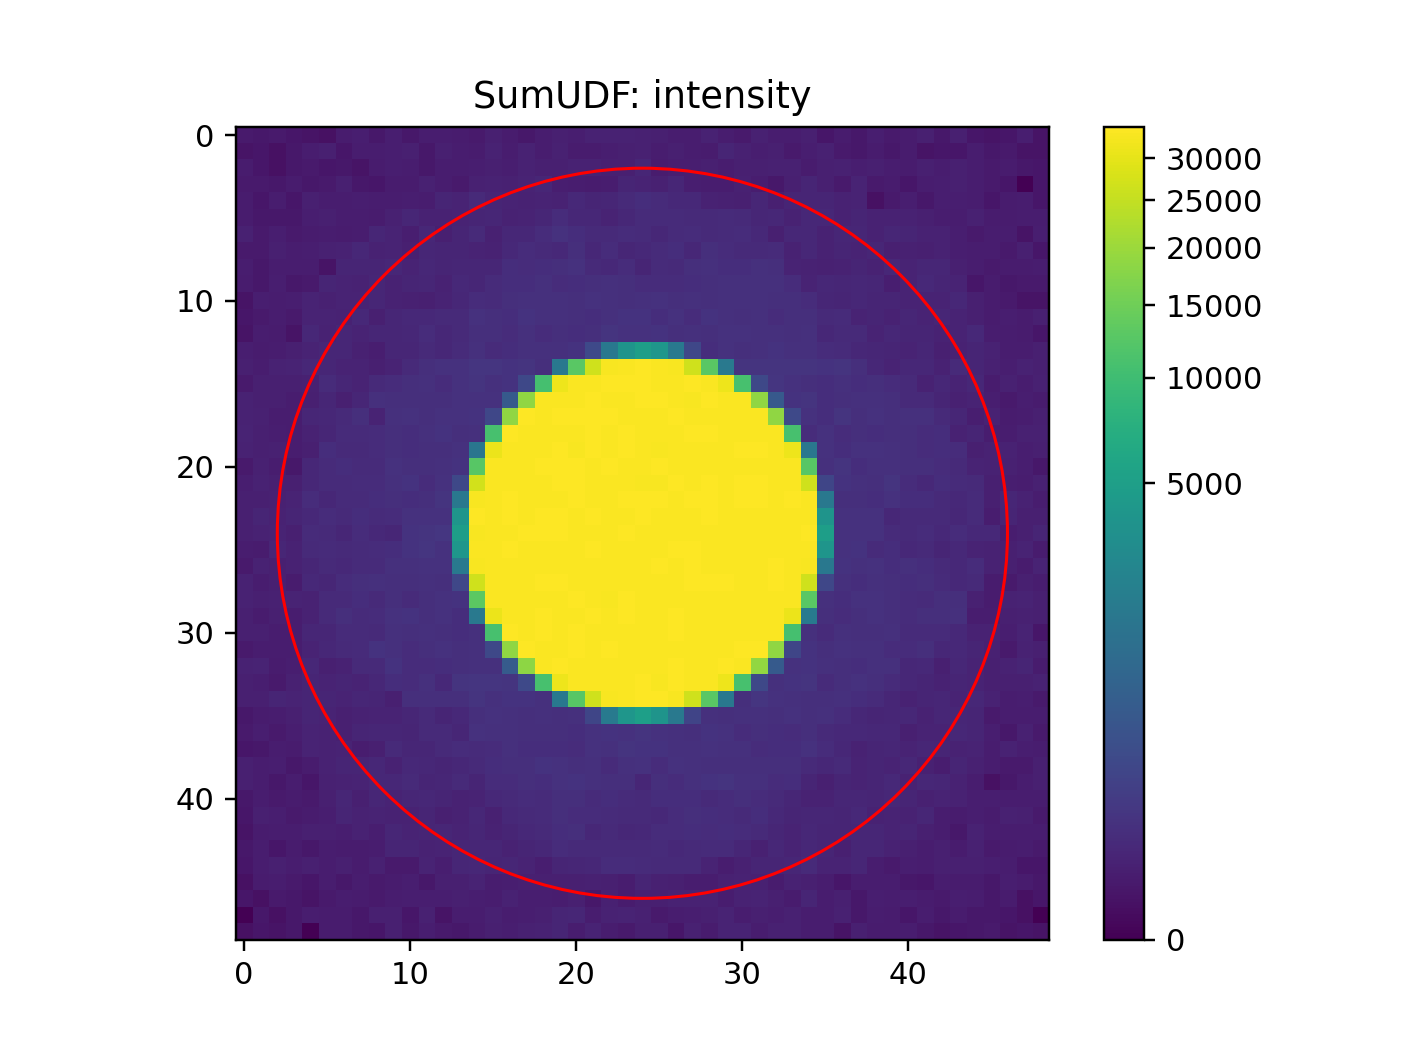

Partitions 0/1, Frames:   0%|          | 0/2025 [00:00<?, ?it/s]

Live plot saved as png: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_live_plot.png
Live plot saved as tiff: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_live_plot.tiff
Live plot saved as svg: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_live_plot.svg


In [7]:
sum_udf = SumUDF()

live_plot = MPLLive2DPlot(
    dataset=ds,
    udf=sum_udf,
    norm=colors.PowerNorm(gamma=.3) #this used to be log normal but this transformation causes problems because of 0s
)
live_plot.display()
circ_a = plt.Circle((rec_params["cx"], rec_params["cy"]), rec_params["semiconv_pix"], fill=False, color='red')
live_plot.axes.add_artist(circ_a)
live_plot.fig.colorbar(live_plot.im_obj)

sum_result = inline_ctx.run_udf(dataset=ds, udf=sum_udf, plots=[live_plot], progress=True)
# Save the figure to a file



# Get the name of the input HDF5 file without the extension
input_filename_without_extension = os.path.splitext(os.path.basename(path))[0]

# Define the output directory path (subfolder)
output_directory = os.path.join(os.path.dirname(path), f"{input_filename_without_extension}_output_plots")
os.makedirs(output_directory, exist_ok=True)

# Define the output filenames for different formats
input_filename_without_extension = os.path.splitext(os.path.basename(path))[0]
output_filenames = {
    "png": os.path.join(output_directory, f"{input_filename_without_extension}_live_plot.png"),
    "tiff": os.path.join(output_directory, f"{input_filename_without_extension}_live_plot.tiff"),
    "svg": os.path.join(output_directory, f"{input_filename_without_extension}_live_plot.svg")
}

# ... (your LiberTEM and other code here) ...

# Save the figure to multiple file formats within the output directory
canvas = FigureCanvas(live_plot.fig)
for format, filename in output_filenames.items():
    canvas.print_figure(filename, dpi=300, bbox_inches="tight", format=format)
    print(f"Live plot saved as {format}:", filename)

In [8]:
%%time
trotters = generate_masks(**rec_params, **mask_params)


CPU times: user 4.61 s, sys: 95.8 ms, total: 4.7 s
Wall time: 4.7 s


<IPython.core.display.Javascript object>


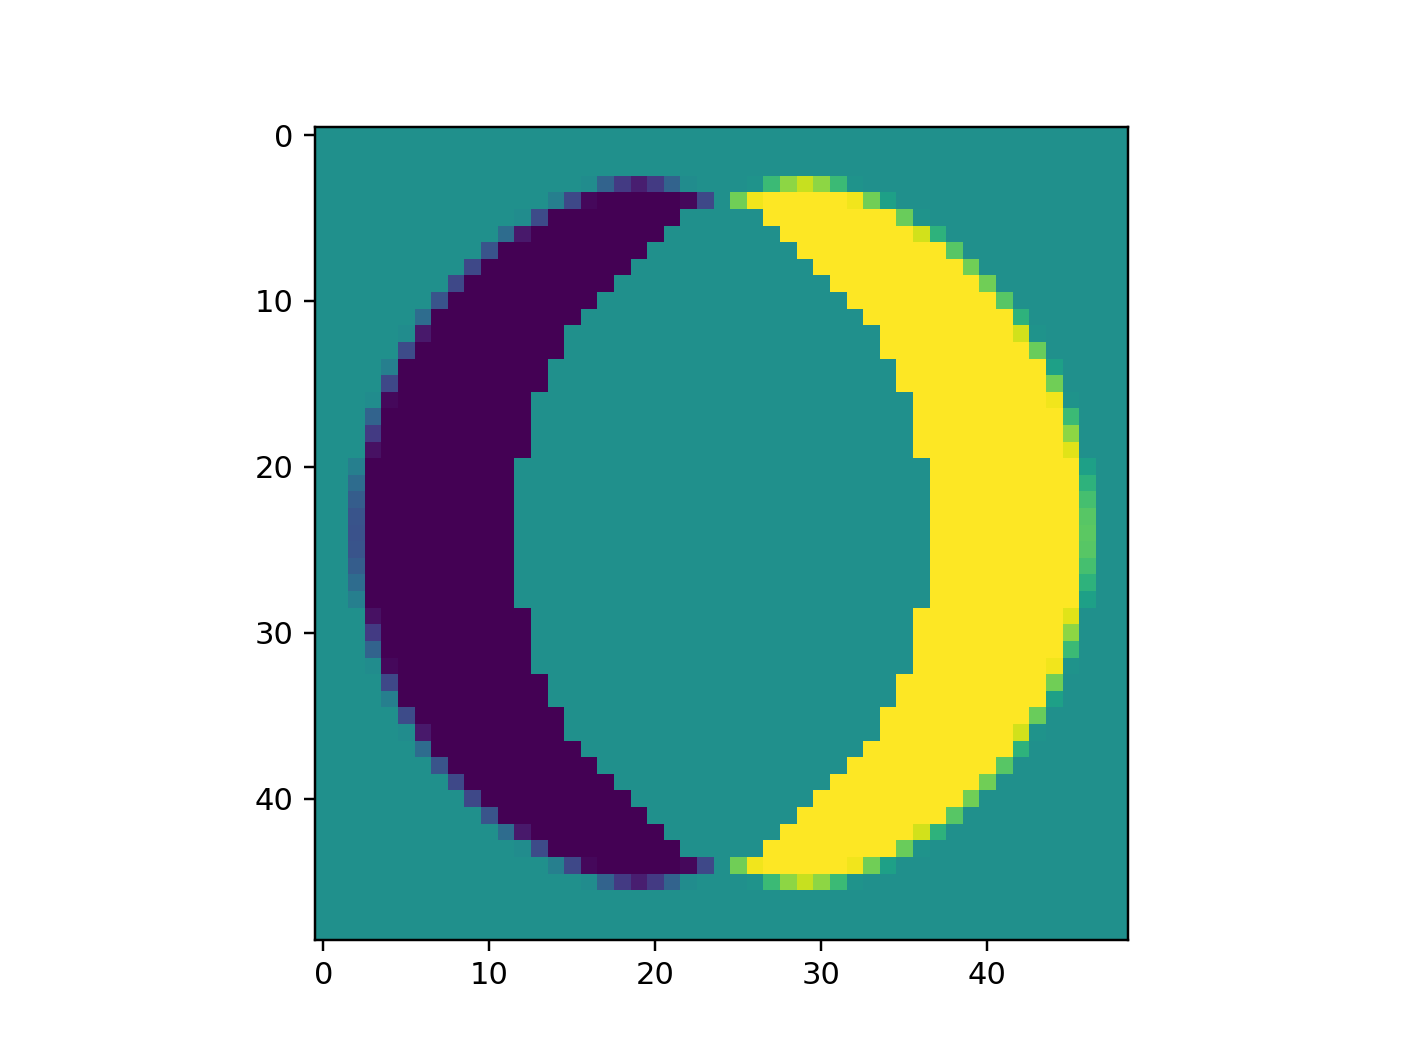

Image saved as png: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_imshow_output.png
Image saved as tiff: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_imshow_output.tiff
Image saved as svg: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/4DSTEM_B4InFluence_imshow_output.svg


In [9]:
fig, axes = plt.subplots()
axes.imshow(trotters[1].todense())

# Get the name of the input HDF5 file without the extension
input_filename_without_extension = os.path.splitext(os.path.basename(path))[0]

# Define the output directory path (subfolder)
output_directory = os.path.join(os.path.dirname(path), f"{input_filename_without_extension}_output_plots")
os.makedirs(output_directory, exist_ok=True)

# Save the figure to multiple file formats within the output directory
input_filename_without_extension = os.path.splitext(os.path.basename(path))[0]
output_filenames = {
    "png": os.path.join(output_directory, f"{input_filename_without_extension}_imshow_output.png"),
    "tiff": os.path.join(output_directory, f"{input_filename_without_extension}_imshow_output.tiff"),
    "svg": os.path.join(output_directory, f"{input_filename_without_extension}_imshow_output.svg")
}

canvas = FigureCanvas(fig)
for format, filename in output_filenames.items():
    canvas.print_figure(filename, dpi=300, bbox_inches="tight", format=format)
    print(f"Image saved as {format}:", filename)

In [10]:
set_use_cuda(0)
#set_use_cuda(1)

In [11]:
mask_container = MaskContainer(
    mask_factories=lambda: trotters, dtype=trotters.dtype, count=trotters.shape[0]
)

In [12]:
udf = SSB_UDF(**rec_params, mask_container=mask_container)


<IPython.core.display.Javascript object>


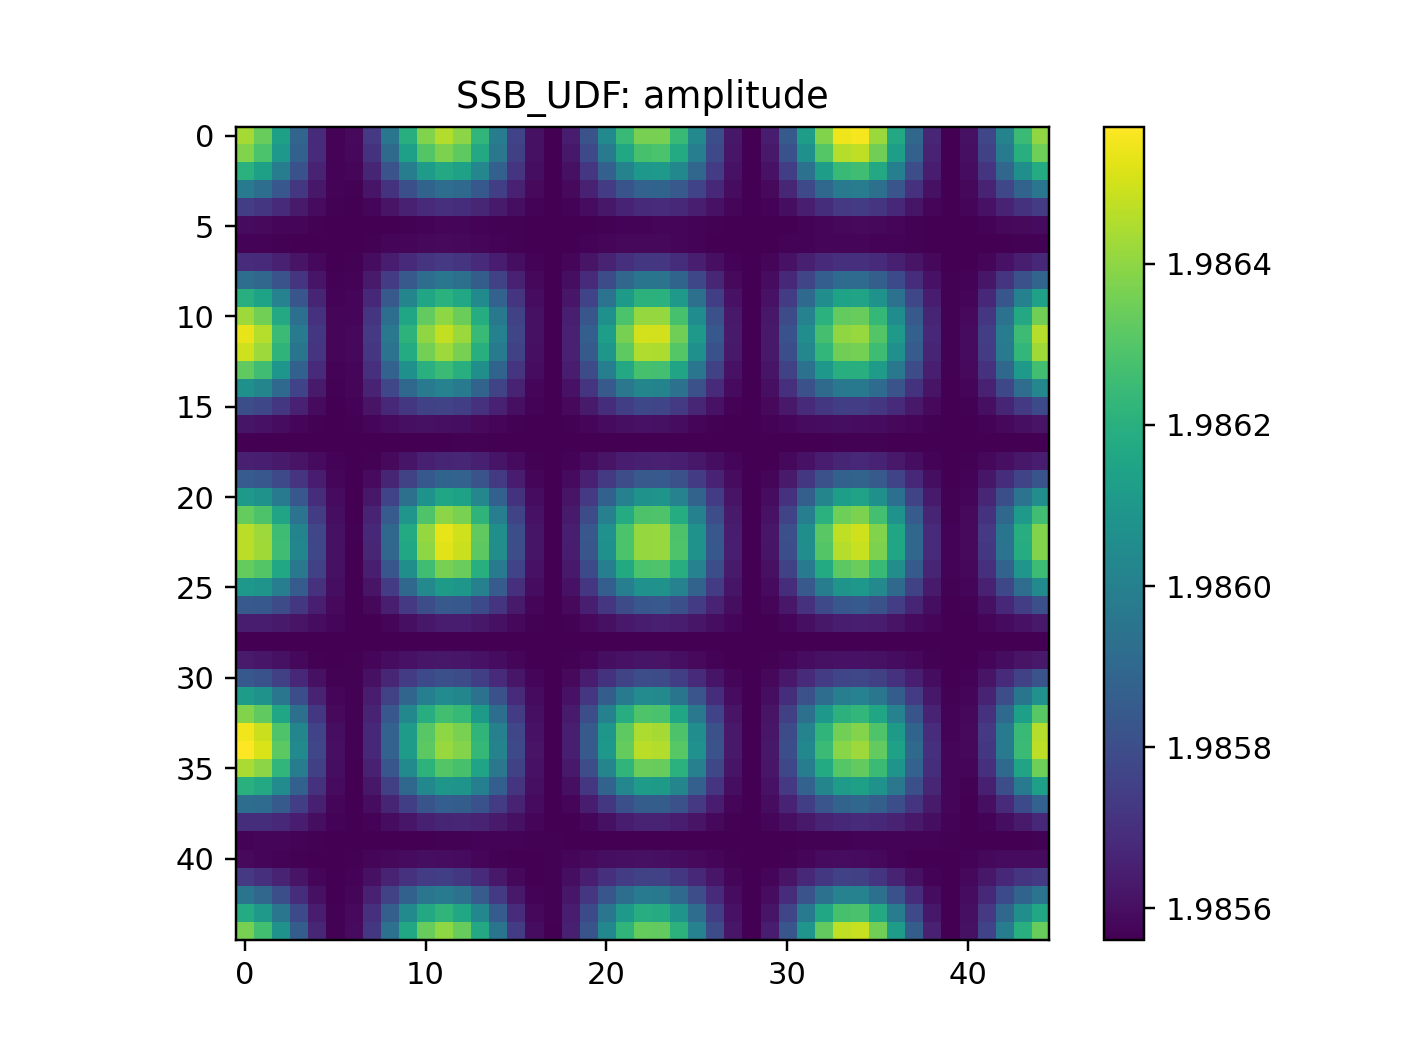

<IPython.core.display.Javascript object>


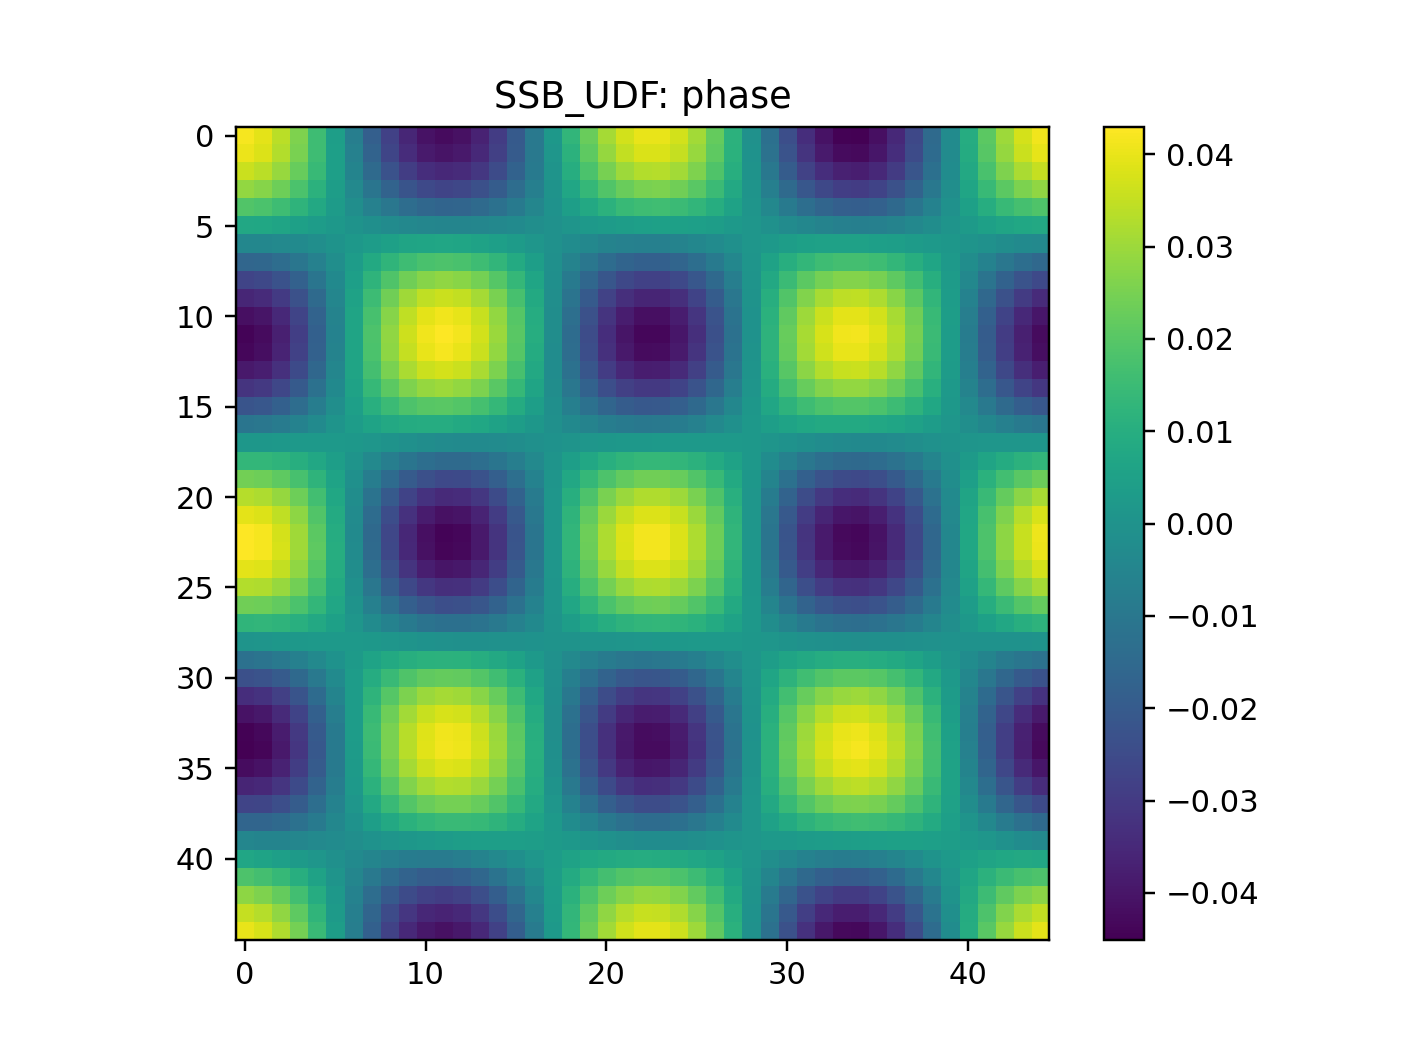

In [13]:
ssb_plots = []

for channel in 'amplitude', 'phase':
    p = MPLLive2DPlot(
        dataset=ds,
        udf=udf,
        channel=channel,
    )
    p.display()
    p.fig.colorbar(p.im_obj)
    ssb_plots.append(p)
    

In [14]:
%%time
# We use the inline executor since the sparse matrix stack is quite large.
# Instead of process-based parallelism, we use multithreading in the UDF.
# This allows to re-use the masks and the cache of MaskContainer between partitions.
udf_result = inline_ctx.run_udf(udf=udf, dataset=ds, plots=ssb_plots, progress=True)

Partitions 0/1, Frames:   0%|          | 0/2025 [00:00<?, ?it/s]

CPU times: user 444 ms, sys: 64 ms, total: 508 ms
Wall time: 509 ms


In [15]:
# Get the name of the input HDF5 file without the extension
input_filename_without_extension = os.path.splitext(os.path.basename(path))[0]

# Define the output directory path (subfolder)
output_directory = os.path.join(os.path.dirname(path), f"{input_filename_without_extension}_output_plots")
os.makedirs(output_directory, exist_ok=True)

# Save each ssb_plot in multiple file formats within the output directory
for index, plot in enumerate(ssb_plots):
    output_filenames = {
        "png": os.path.join(output_directory, f"ssb_plot_{index}_channel_{plot.channel}_plot.png"),
        "tiff": os.path.join(output_directory, f"ssb_plot_{index}_channel_{plot.channel}_plot.tiff"),
        "svg": os.path.join(output_directory, f"ssb_plot_{index}_channel_{plot.channel}_plot.svg")
    }

    canvas = FigureCanvas(plot.fig)
    for format, filename in output_filenames.items():
        canvas.print_figure(filename, dpi=300, bbox_inches="tight", format=format)
        print(f"SSB plot (channel: {plot.channel}) saved as {format}:", filename)


SSB plot (channel: amplitude) saved as png: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_plot_0_channel_amplitude_plot.png
SSB plot (channel: amplitude) saved as tiff: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_plot_0_channel_amplitude_plot.tiff
SSB plot (channel: amplitude) saved as svg: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_plot_0_channel_amplitude_plot.svg
SSB plot (channel: phase) saved as png: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_plot_1_channel_phase_plot.png
SSB plot (channel: phase) saved as tiff: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_plot_1_channe

In [16]:
amplitude_output_filename = os.path.join(output_directory, "ssb_amplitude_data.npy")
phase_output_filename = os.path.join(output_directory, "ssb_phase_data.npy")

np.save(amplitude_output_filename, ssb_plots[0].data)  # Save amplitude data
np.save(phase_output_filename, ssb_plots[1].data)  # Save phase data

print("SSB amplitude data saved to:", amplitude_output_filename)
print("SSB phase data saved to:", phase_output_filename)

SSB amplitude data saved to: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_amplitude_data.npy
SSB phase data saved to: /media/andystewart/Samsung_T5/2023/2023_PtychographyExperiments/ImagingMicroscopy/6000_dose/4DSTEM_B4InFluence_output_plots/ssb_phase_data.npy
